# NMFM3311 - Final Project
## Viktor Procházka
------
### Problem 1 - Implement NPV and IRR functions

Task: 
>Define two functions that compute the net present value (NPV) and the internal
rate of return (IRR). Similar functions are already implemented in the numpy library,
but your implementation should compute it directly and use the existing functions
only as a check for the correctness. The function NPV should be a function of (rate,
cash flow), the IRR should be a function of a (cash flow).

Net present value is defined as follows
$$ \text{NPV}= \sum_{t = 0}^n \frac{R_t}{(1+i)^t}  $$
where $R_t$ is cashflow at time $t$ and $i$ is the discount rate.

Internal rate of return is defined by the following property
$$ \sum_{t = 0}^n \frac{R_t}{(1+\text{IRR})^t} = 0 $$
where IRR is the internal rate of return.

Calculation of the NPV is straightforward as all we need to do is to evaluate the polynomial given by the definition. To do this calculation in $O(n)$ we use Horner's method for polynomial evaluation.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt, exp
import scipy.stats as stat
from matplotlib.ticker import PercentFormatter
from scipy.optimize import minimize

In [2]:
def NPV(discount_factor, cashflow_list):
    """Calculates the NPV for given discount factor and list of cashflow """
    
    npv_value = 0
    discount_quotient = 1/(1+discount_factor)
    
    for i in range(len(cashflow_list)):
        npv_value = npv_value * discount_quotient
        npv_value += cashflow_list[-i-1]
        
    return npv_value

def NPV_vectorized(discount_factor, cashflow_list):
    npv_factor = lambda i, r, t : r*1/(1+i)**t
    discount_vector = [discount_factor for x in cashflow_list]
    return sum(map(npv_factor, discount_vector, cashflow_list, range(len(cashflow_list))))

print(f'NPV to be calculated:      -0.00847859163845488')
print(f'Calculated NPV - Horner:   {NPV(0.281,[-100, 39, 59, 55, 20])}')
print(f'Calculated NPV - standard: {NPV_vectorized(0.281,[-100, 39, 59, 55, 20])}')

NPV to be calculated:      -0.00847859163845488
Calculated NPV - Horner:   -0.00847859163846465
Calculated NPV - standard: -0.00847859163845488


Calculation of the IRR is not so easy, since it requires us to solve a polynomial equation. To do this, we will resort to using python's numerical library numpy with its integrated polynomial equation solver.

In [3]:
from numpy import roots as polynomial_solver

def IRR(cashflow_list):
    """Calculates the NPV for given list of cashflow """
    """We first solve a polynomial equation and from all its solutions we select the real and nonnegative solution"""
    
    possible_solutions = polynomial_solver(cashflow_list)
    solution = [np.real(x-1) for x in possible_solutions if (np.isreal(x)) and (np.real(x) > 0)][0]
    return solution
    
def irr_patrik(cashflow):
    roots_list = np.roots(cashflow)
    for root in roots_list:
        if (np.isreal(root)) and (root.real > 0):
            return (root - 1).real
    
print(irr_patrik([-100, 39, 59, 55, 20]))
print(f'IRR to be calculated: 0.28094842115996066')
print(f'Calculated IRR:       {IRR([-100, 39, 59, 55, 20])}')

0.280948421159962
IRR to be calculated: 0.28094842115996066
Calculated IRR:       0.280948421159962


### Problem 2 - Monte Carlo Simulation of Asset Prices
We begin by setting the following constants and generating log-return data, which is normaly distributed. This data is then summed to cumulative log return and exponentiated to asset price development.

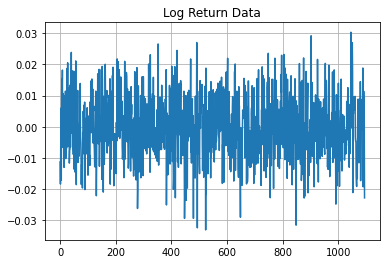

In [4]:
from numpy.random import normal as log_return_data_generator

sigma = 0.2 
T = 3 #years
n = T*365

dt = T/n
log_return = log_return_data_generator(0, sigma*sqrt(dt), n)
plt.plot(log_return)
plt.grid(True)
plt.title('Log Return Data')
plt.show()

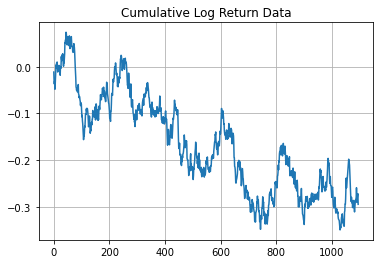

In [5]:
cm_log_return = [sum(log_return[0:x+1]) for x in range(n)]
plt.plot(cm_log_return)
plt.grid(True)
plt.title('Cumulative Log Return Data')
plt.show()

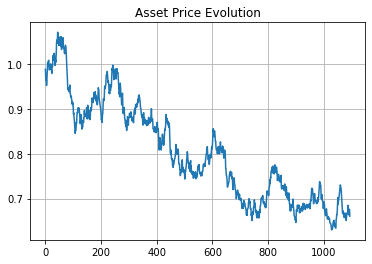

In [6]:
price = [exp(cm_log_return[x]-sigma**2*dt*x) for x in range(len(cm_log_return))] #tohle je divny v zadani, konzultovat
func = lambda x, y: x-y-1
plt.plot(price)

plt.grid(True)
plt.title('Asset Price Evolution')
plt.show()

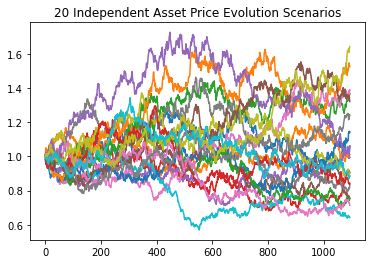

In [7]:
plt.clf()
for i in range(20):
    multi_log_return = log_return_data_generator(0, sigma*sqrt(dt), n)
    multi_cm_log_return = [sum(multi_log_return[0:x+1]) for x in range(n)]
    s = [exp(multi_cm_log_return[t]) for t in range(n)] #tohle je divny v zadani, konzultovat
    plt.plot(s)
plt.title('20 Independent Asset Price Evolution Scenarios')
plt.show()

### Problem 3 - Monte Carlo Simulation for Valuation


In [8]:
def coupon_count(bound, values):
    for i in range(len(values)-1, -1, -1):
        if values[i] >= bound:
            return i+1
    return 0


def find_first_index_over(bound, values):
    for i in range(len(values)):
        if values[i] >= bound:
            return i    
    return len(values) -1


def contract_payoff(sigma):
    n = 6
    coupon = 2.5
    log_returns = log_return_data_generator(0, sigma, n)
    cm_log_return = [sum(log_returns[0:x+1]) for x in range(n)]
    values = [exp(cm_log_return[x]-sigma**2*0.5*x) for x in range(len(cm_log_return))] #tohle je divny v zadani, konzultovat
    values = values[:find_first_index_over(1, values) +1]
    number_of_coupons = coupon_count(0.8, values)
    
    if values[-1] >= 0.6:
        return 100 + number_of_coupons*coupon
    else:
        return 100*values[-1] + number_of_coupons*coupon
    


In [9]:
contract_payoff(0.2)

102.5

In the following section, we will estimate the expected payoff. To do this, we will use the mean estimator, which has a standard deviation of $\sqrt{\frac{\sigma^2_X}{n}}$. \
Additionally, we will construct an interval estimate using the following relation



$$ \sqrt{n} \; \frac{\overline{X}_n - \mu_X}{S_n} \sim T^{n-1}$$
which yields the following confidance interval
$$ \mathbb{P}\left(\overline{X}_n -T_{\alpha /2}^{n-1}\frac{S_n }{\sqrt{n}} \leq \mu_X \leq \overline{X}_n +T_{\alpha/2}^{n-1}\frac{S_n }{\sqrt{n}} \right) = 1-\alpha$$
where $T_{\alpha/2}$ marks the $\frac{\alpha}{2}$-th quantile of student's T distribution.

In [10]:
def contract_data(sigma, n):
    return [fancy_contract(sigma) for x in range(n)]

def t_statistic_mean_confidence_interval(data, alpha):
    mean = np.mean(data)
    s_n = np.std(data, ddof = 1)
    n = len(data)
    left_t_bound, right_t_bound = stat.t.interval(1-alpha, n)
    

    return (mean - right_t_bound*s_n/sqrt(n), mean-left_t_bound*s_n/sqrt(n))
    

In [11]:
#Janko style exponencializace

def contract_payoff(sigma):
    n = 6
    coupon = 2.5
    
    S=np.empty(n+1)
    S[0]=1
    T = 3
    n = 6
    dt=T/n
    time =np.arange(0,T+dt,dt)
    logreturns= np.random.normal(0, sigma*((dt)**(0.5)), n)
    cmlogret=np.append(0,np.cumsum(logreturns)) 
    S=S[0]*np.exp(cmlogret-0.5*(sigma**2)*time)
    
    #print(S)
    values = S.tolist()[1:]
    values = values[:find_first_index_over(1, values) +1]
    #print(values)
    number_of_coupons = coupon_count(0.8, values)
    
    if values[-1] >= 0.6:
        return 100 + number_of_coupons*coupon
    else:
        return 100*values[-1] + number_of_coupons*coupon
    


In [12]:
alpha = 0.05
sigma = 0.25
n = 10000 #takes roughly 2*(n/10^5) seconds to generate data

from time import time
tic = time()

data = [contract_payoff(sigma) for x in range(n)]

toc = time()
print('time to generate data: {:.2f} seconds'.format(toc-tic))
interval = t_statistic_mean_confidence_interval(data, alpha)


print('sample mean = {:.2f}'.format(np.mean(data)))
print('sample standard deviation = {:.2f}'.format(np.std(data, ddof = 1)))
print('mean standard deviation: {:.2f}'.format(np.std(data, ddof = 1)/sqrt(n) ))
print('confidance interval covering expected payoff with probability of 1-alpha: ({:.5f}, {:.5f})'.format(interval[0], interval[1]))

time to generate data: 0.32 seconds
sample mean = 98.98
sample standard deviation = 17.95
mean standard deviation: 0.18
confidance interval covering expected payoff with probability of 1-alpha: (98.62797, 99.33188)


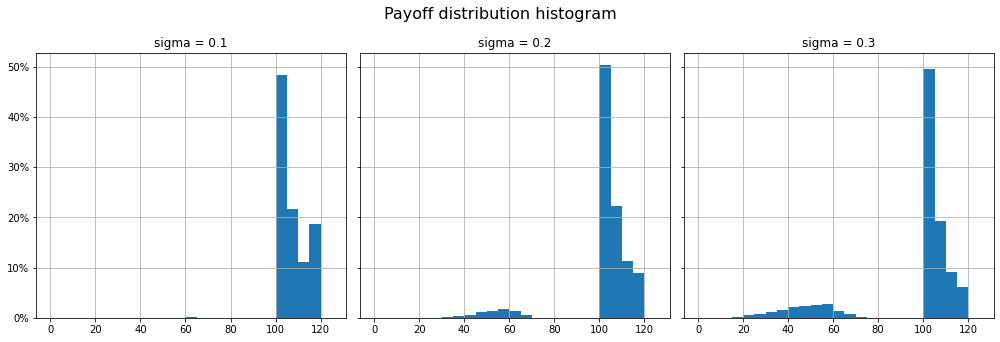

In [13]:
n = 10000
sigma = [0.1, 0.2, 0.3] #list of sigmas for comparisson

data = [[contract_payoff(sigma_val) for x in range(n)] for sigma_val in sigma]


fig, ax = plt.subplots(1, len(data), figsize=(14, 4.8), sharey=True, tight_layout=True)
fig.suptitle('Payoff distribution histogram', fontsize=16)

for i in range(len(data)):
    ax[i].hist(data[i], [x for x in range(130) if x%5 == 0],  weights=np.ones(len(data[i]))/len(data[i]))
    ax[i].grid(True)
    ax[i].set_title("sigma = {}".format(sigma[i]))


fig.gca().yaxis.set_major_formatter(PercentFormatter(1))

### Problem 4 - Optimal portfolio

In [14]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import time

np.random.seed(92943209)

table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
all_tickers = table['Symbol'].tolist()


all_tickers = [ticker.replace('.', '-') for ticker in all_tickers]

tickers = np.random.choice(all_tickers, 10, replace = False)
start_date = '2019-01-01'
end_date = time.strftime("%Y-%m-%d")
sp500 = data.DataReader(tickers, 'yahoo', start_date, end_date)['Adj Close'] #this one takes a while...

In [15]:
print(sp500['HPE'].index[0])
print('Tickers with different starting date: ', end = '')
print( [ ticker for ticker in tickers if sp500[ticker].index[0] != sp500['HPE'].index[0]])

2019-01-02 00:00:00
Tickers with different starting date: []


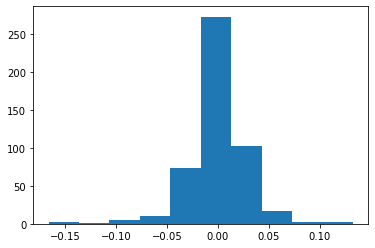

In [16]:
plt.hist((sp500.pct_change().apply(lambda x: np.log(1+x))['HPE']))
plt.show()

In [17]:
sigma = sp500.pct_change().apply(lambda x: np.log(1+x)).cov().to_numpy()
cov_matrix = sp500.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

Symbols,WDC,LYV,ALL,SJM,MPC,VRSN,AES,HPE,TPR,CMG
Symbols,,,,,,,,,,
WDC,0.001448,0.000726,0.000432,0.000054,0.000888,0.000377,0.000561,0.000621,0.000838,0.000389
LYV,0.000726,0.001225,0.000403,0.000031,0.000862,0.000270,0.000554,0.000524,0.000807,0.000399
ALL,0.000432,0.000403,0.000438,0.000119,0.000569,0.000252,0.000390,0.000322,0.000468,0.000236
SJM,0.000054,0.000031,0.000119,0.000306,0.000101,0.000128,0.000069,0.000084,0.000153,0.000026
MPC,0.000888,0.000862,0.000569,0.000101,0.001669,0.000327,0.000755,0.000748,0.000973,0.000365
VRSN,0.000377,0.000270,0.000252,0.000128,0.000327,0.000410,0.000265,0.000239,0.000367,0.000252
AES,0.000561,0.000554,0.000390,0.000069,0.000755,0.000265,0.000785,0.000430,0.000603,0.000349
HPE,0.000621,0.000524,0.000322,0.000084,0.000748,0.000239,0.000430,0.000781,0.000747,0.000212
TPR,0.000838,0.000807,0.000468,0.000153,0.000973,0.000367,0.000603,0.000747,0.001839,0.000263


In [49]:
print("positive definite check:")
print(np.all(np.linalg.eigvals(cov_matrix) > 0))

positive definite check:
True


[ 7.52309147e-04  7.56729430e-04  6.09212426e-04  5.87470607e-04
 -5.03820722e-04  6.90047003e-04  9.58849873e-04 -6.64813437e-05
 -1.83781675e-04  2.27563619e-03]
[0.00144787 0.00122477 0.00043801 0.00030569 0.00166876 0.00041011
 0.00078497 0.00078054 0.00183858 0.00063776]


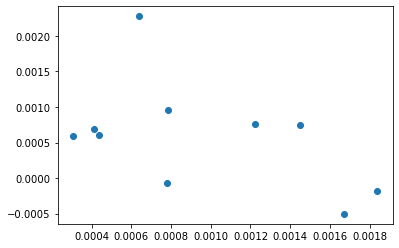

In [48]:
E = sp500.pct_change().apply(lambda x: np.log(1+x)).mean().to_numpy()
print(E)
var = sigma.diagonal()
print(var)
plt.plot(var, E, 'o')
plt.show()

[0.00144787 0.00122477 0.00043801 0.00030569 0.00166876 0.00041011
 0.00078497 0.00078054 0.00183858 0.00063776]


In [42]:
def objective(w):
    return w.T.dot(sigma.dot(w))

def weights_sum_constraint(w):
    return np.ones(10).T.dot(w) -1

def expected_return_constraint(w):
    return E.T.dot(w)-e

bound_interval = (0, 1)

bnds = tuple([bound_interval for stock in tickers])
con1 = {'type': 'eq', 'fun': weights_sum_constraint}
con2 = {'type': 'eq', 'fun': expected_return_constraint}
cons = [con1, con2]

e = E.T.dot(0.1*np.ones(10))

from scipy.optimize import minimize
x_0 = 0.1*np.ones(10)
solution = minimize(objective, x_0, method = 'SLSQP', bounds = bnds, constraints = cons, tol = 0.000001)

E_min = sp500.pct_change().apply(lambda x: np.log(1+x)).mean().min()
E_max = sp500.pct_change().apply(lambda x: np.log(1+x)).mean().max()


steps = 1000


frontier_data = []
for i in range(steps):
    e = i*(E_max-E_min)/steps
    w = minimize(objective, x_0, method = 'SLSQP', bounds = bnds, constraints = cons, tol = 0.000001).x
    var = objective(w)
    frontier_data.append([e, var, w])


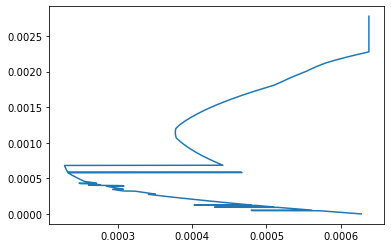

In [44]:
frontier_x = [f[1] for f in frontier_data]
frontier_y = [f[0] for f in frontier_data]
plt.plot(frontier_x, frontier_y)
plt.show()